## Dataset download

In [ ]:
from google.colab import files
files.upload()
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c spaceship-titanic

Saving kaggle.json to kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 93.0MB/s]


In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 9s (45.5 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+c

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import random

## Extract the zip file

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("spaceship-titanic.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

## Data import

In [ ]:
xytot = []
xtot = []
ytot = []
xs = []
ys = []
xvalid = []
yvalid = []

with open("tmp/train.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader:
    xytot.append(row)

group_x = []
random.shuffle(xytot)

for row in xytot:
  xtot.append(row[:-1])
  ytot.append(1 if row[-1] == "True" else 0)
  if row[-1] == "True" and row[0] not in group_x:
    group_x.append(row[0])

xs = xtot[:(int)(len(xtot)*0.8)]
ys = ytot[:(int)(len(xtot)*0.8)]
xvalid = xtot[(int)(len(xtot)*0.8):]
yvalid = ytot[(int)(len(xtot)*0.8):]

## Visualize some data

In [ ]:
x_sample = xs[:10]

for i, x in enumerate(x_sample):
  print(f"Row {i}: {x}")

Row 0: ['2479_01', 'Earth', 'True', '', 'PSO J318.5-22', '21.0', 'False', '0.0', '0.0', '0.0', '0.0', '0.0', 'Joela Gordanieves']
Row 1: ['6468_02', 'Mars', 'True', 'F/1339/P', 'TRAPPIST-1e', '8.0', 'False', '0.0', '0.0', '0.0', '0.0', '0.0', 'Guans Crité']
Row 2: ['7693_01', 'Europa', 'False', 'B/252/P', 'TRAPPIST-1e', '36.0', 'False', '0.0', '2979.0', '0.0', '68.0', '347.0', 'Cherrak Roftfuling']
Row 3: ['3181_01', 'Earth', 'False', 'E/197/P', 'TRAPPIST-1e', '20.0', 'False', '4.0', '353.0', '193.0', '241.0', '0.0', 'Tanley Gregordy']
Row 4: ['6921_02', 'Europa', 'True', 'C/255/S', '55 Cancri e', '24.0', 'False', '0.0', '0.0', '0.0', '', '0.0', 'Eleron Fordulgaug']
Row 5: ['4476_01', 'Earth', 'False', 'F/921/P', 'TRAPPIST-1e', '26.0', 'False', '1170.0', '0.0', '0.0', '187.0', '100.0', 'Brancy Miranciash']
Row 6: ['9157_03', 'Earth', 'False', 'G/1476/S', 'PSO J318.5-22', '10.0', 'False', '0.0', '0.0', '0.0', '0.0', '0.0', 'Andrey Navages']
Row 7: ['5287_01', 'Earth', 'False', 'G/861/S'

## Manage the data

In [ ]:
def prepare_data(xs):
  hp = []
  xs_tv = []
  cabins = []
  dests = []
  surs = []
  for row in xs:
    group = (int) (row[0].split("_")[0])
    if row[1]  != "" and row[1] not in hp:
      hp.append(row[1])
    cryosleep = 0 if row[2] == "" else 1 if row[2] == 'True' else 0.5
    if row[3]  != "":
      if row[3] not in cabins:
        cabins.append(row[3])
    if row[4] not in dests:
      dests.append(row[4])

    x_tv = []
    #x_tv.append((float) (group/9280)) # the group
    x_tv.append((hp.index(row[1])+1)/3 if row[1]  != "" else 0) # home planet
    x_tv.append(1 if row[1] == "" else 0) # home planet null
    x_tv.append(cryosleep) # cryosleep
    x_tv.append(1 if row[2] == "" else 0) #cryosleep null
    x_tv.append((cabins.index(row[3])+1)/6000 if row[3] != "" else 0) # cabin
    x_tv.append(1 if row[3] == "" else 0) # cabin null
    x_tv.append((dests.index(row[4])+1)/3  if row[4]  != "" else 0) # destination
    x_tv.append(1 if row[4] == "" else 0)
    x_tv.append(((float)(row[5]) / 100 if row[5]  != "" else 0)) # age
    x_tv.append(1 if row[5] == "" else 0) # age null
    x_tv.append(0 if row[6] == "" else 1 if row[6] == "True" else 0.5) # vip
    x_tv.append(0 if row[7] == "" else (float)(row[7])/20000)
    x_tv.append(0 if row[8] == "" else (float)(row[8])/20000)
    x_tv.append(0 if row[9] == "" else (float)(row[9])/20000)
    x_tv.append(0 if row[10] == "" else (float)(row[10])/20000)
    x_tv.append(0 if row[11] == "" else (float)(row[11])/20000)
    x_tv.append(1 if row[7] == "" else 0) 
    x_tv.append(1 if row[8] == "" else 0)
    x_tv.append(1 if row[9] == "" else 0)
    x_tv.append(1 if row[10] == "" else 0)
    x_tv.append(1 if row[11] == "" else 0) 
    x_tv.append(1 if row[12] == "" else 0)
    #x_tv.append((float) (spent / 100000)) # money spent on board
    surname = row[12].split(" ")[1] if row[12] != "" else None
    if surname is not None and surname not in surs:
      surs.append(surname)
    x_tv.append(0 if surname is None else (float)(surs.index(surname) / 700))
    xs_tv.append(np.array(x_tv, dtype=np.float64))
  return xs_tv

xs_train = prepare_data(xs)
xs_valid = prepare_data(xvalid)
xtot_np = np.array(prepare_data(xtot))

## Visualize the new input data

In [ ]:
xs_train_sample = xtot_np[:10]


for i, x in enumerate(xs_train_sample):
  print(f"Row {i}: {x}, y={ys[i]}")

## Model creation and compile

In [ ]:
LOSS_CONST = 30e-6

xs_train_np = np.array(xs_train)
xs_valid_np = np.array(xs_valid)

print(xs_train_np.shape)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(LOSS_CONST), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(LOSS_CONST), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(LOSS_CONST), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(LOSS_CONST), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(LOSS_CONST), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
    ])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
    metrics = ['accuracy']
)


(6954, 23)


## Model train

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(np.array(xtot_np), np.array(ytot),  batch_size=32,epochs=100)

## Plot result

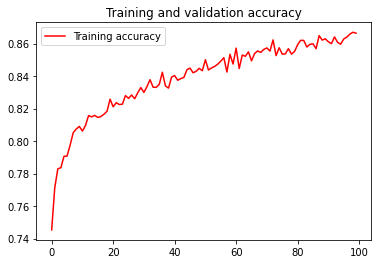

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
xtot = []

with open("tmp/test.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader:
    xtot.append(row)

x = np.array(prepare_data(xtot))

prediction = []

for i in range(0,len(x)):
  new_x = np.expand_dims(x[i], 0)
  pred = model.predict(new_x)[0]
  prediction.append(np.array([xtot[i][0],"True" if pred > 0.5 else "False"]))


In [ ]:
for pr in prediction:
  print(pr)
  

In [ ]:
from os import writev
fields = ['PassengerId', 'Transported'] 

with open("tmp/sample_submission.csv", 'w', newline='') as myfile:
    write = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    write.writerow(fields)
    write.writerows(prediction)

## LR tuning

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

# Train the model
history = model.fit(xs_train_np, np.array(ys), batch_size=64, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
 82/123 [===================>..........] - ETA: 0s - loss: 0.2954

KeyboardInterrupt: ignored

## Plot the result

(0.0001, 0.009, 0.4, 0.6)

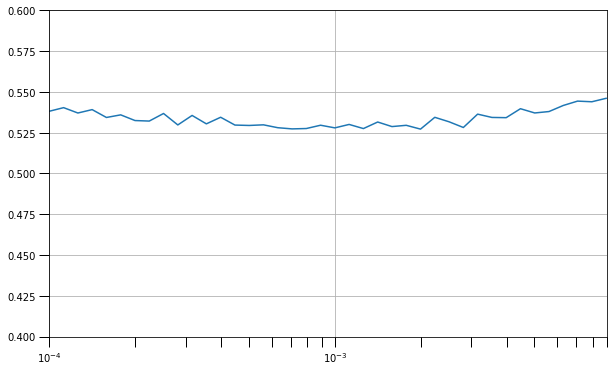

In [ ]:
import numpy as np
# Define the learning rate array
lrs = 1e-4 * (10 ** (np.arange(40) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-4, 9e-3, 0.4, 0.6])